In [62]:
import pymongo as pmn
from sshtunnel import SSHTunnelForwarder
import pprint
import datetime
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

%matplotlib inline

# Инициализация базы

In [2]:
MONGO_HOST = "10.2.81.40"
MONGO_DB = "VectorX_DWH"
MONGO_PORT = 65372

In [4]:
server = SSHTunnelForwarder(
    ssh_address_or_host=("10.2.81.40"),
    ssh_username="mmartinson",
    ssh_password="hyklapy",
    remote_bind_address=('127.0.0.1', 27017),
)

server.start()

client = pmn.MongoClient('127.0.0.1', server.local_bind_port) # server.local_bind_port is assigned local port
db = client[MONGO_DB]
pprint.pprint(db.collection_names())
server.stop()

['documents', 'topic_by_date']


In [5]:
server.stop()

In [6]:
server.start()
client = pmn.MongoClient('127.0.0.1', server.local_bind_port) # server.local_bind_port is assigned local port
db = client[MONGO_DB]
docs = db.documents

# Вспомогательные функции

In [6]:
def write_list_to_csv(lst, filename):
    pd.DataFrame(list(lst)).to_csv(filename)

# Выкачивание данных

In [84]:
docs.find_one()['rss_pubDate']#['channel']['item']['pubDate']

datetime.datetime(2017, 8, 1, 0, 0, 2)

### Про таблицу

#### Всего записей

In [17]:
%%time
TOTAL_DOCUMENTS = docs.count()
print(TOTAL_DOCUMENTS)

2060904
CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 75.8 ms


#### Распределения

[related stack overflow](https://stackoverflow.com/questions/25646027/group-query-upon-nested-object-in-mongodb?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa)

[related 2 stack overflow](https://stackoverflow.com/questions/36645838/count-how-many-documents-contain-a-field?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa)

[related](https://smyl.es/how-to-count-the-number-of-values-found-for-a-field-in-mongodb-using-node-js-and-mongoose-using-aggregation/)

In [18]:
lvl1 = pd.DataFrame(columns=list(lvl1_names))
cur_time = datetime.datetime(2017, 8, 1, 0, 0, 0)
delta = datetime.timedelta(hours=1)

default_nicht = {
 'lvl1_бизнес' : 0,
 'lvl1_культура' : 0,
 'lvl1_медиа' : 0,
 'lvl1_наука_и_техника' : 0,
 'lvl1_общество_и_путешествия' : 0,
 'lvl1_политика' : 0,
 'lvl1_происшествия' : 0,
 'lvl1_силовые_структуры' : 0,
 'lvl1_спорт' : 0,
 'lvl1_экономика_и_финансы' : 0}
lvl1 = lvl1.append(default_nicht, ignore_index=True)
lvl1

,lvl1_политика,lvl1_спорт,lvl1_экономика_и_финансы,lvl1_общество_и_путешествия,lvl1_силовые_структуры,lvl1_медиа,lvl1_наука_и_техника,lvl1_происшествия,lvl1_бизнес,lvl1_культура
0,0,0,0,0,0,0,0,0,0,0


In [37]:
%%time
pipeline = [
    {'$project' : {'topiclvl' : {'$arrayElemAt' : ["$topics", 0]}}},
#     {'$unwind': '$topics'},    
    {'$group' : {'_id' : '$topiclvl.lvl1.id', 'counted' : {'$sum' : 1}}}
]
lvl1_dist_cursor = list(docs.aggregate(pipeline=pipeline))

CPU times: user 992 ms, sys: 328 ms, total: 1.32 s
Wall time: 12min 25s


In [38]:
lvl1_dist_cursor

[{'_id': 'lvl1_общество_и_путешествия', 'counted': 772020},
 {'_id': 'lvl1_происшествия', 'counted': 5775},
 {'_id': 'lvl1_экономика_и_финансы', 'counted': 275121},
 {'_id': 'lvl1_медиа', 'counted': 68039},
 {'_id': 'lvl1_наука_и_техника', 'counted': 67820},
 {'_id': 'lvl1_политика', 'counted': 311357},
 {'_id': None, 'counted': 192154},
 {'_id': 'lvl1_культура', 'counted': 213198},
 {'_id': 'lvl1_бизнес', 'counted': 14970},
 {'_id': 'lvl1_спорт', 'counted': 102320},
 {'_id': 'lvl1_силовые_структуры', 'counted': 38130}]

In [40]:
totalsum = 0
for x in lvl1_dist_cursor:
    totalsum += x['counted']
    print(x)
totalsum

{'_id': 'lvl1_общество_и_путешествия', 'counted': 772020}
{'_id': 'lvl1_происшествия', 'counted': 5775}
{'_id': 'lvl1_экономика_и_финансы', 'counted': 275121}
{'_id': 'lvl1_медиа', 'counted': 68039}
{'_id': 'lvl1_наука_и_техника', 'counted': 67820}
{'_id': 'lvl1_политика', 'counted': 311357}
{'_id': None, 'counted': 192154}
{'_id': 'lvl1_культура', 'counted': 213198}
{'_id': 'lvl1_бизнес', 'counted': 14970}
{'_id': 'lvl1_спорт', 'counted': 102320}
{'_id': 'lvl1_силовые_структуры', 'counted': 38130}


2060904

In [41]:
pd.DataFrame(lvl1_dist_cursor).to_csv('./retro/lvl1_total_sum.csv')

___
#### Распределения первого уровня

Создадим индексы:

16:08

In [85]:
docs.create_index([('rss_pubDate', pmn.ASCENDING)])

'rss_pubDate_1'

`Tue, 01 Aug 2017 00:00:02 GMT`

In [95]:
list_lvl1_distr_full_2h = []

start_time = datetime.datetime(2017, 8, 1, 0, 0, 0)
delta = datetime.timedelta(hours=2)

cur_time = 0
while start_time + delta < datetime.datetime(2017, 9, 1, 0, 0, 0):
#     print(start_time)
    cursor = docs.find({"rss_pubDate" : {'$gt' : start_time, '$lt' : start_time + delta}})
    
    pipeline = [
    {'$match' : {"rss_pubDate" : {'$gt' : start_time, '$lt' : start_time + delta}}},
    {'$project' : {'topiclvl' : {'$arrayElemAt' : ["$topics", 0]}}},
    {'$group' : {'_id' : '$topiclvl.lvl1.id', 'counted' : {'$sum' : 1}}}
    ]
    lvl1_sub_cursor = list(docs.aggregate(pipeline=pipeline))
    list_lvl1_distr_full_2h.append(lvl1_sub_cursor)
    start_time += delta
    cur_time += 1
    print(cur_time, end=' ')
    

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [96]:
len(list_lvl1_distr_full_2h)

371

In [107]:
list_lvl1_distr_full_2h[:2]

[[{'_id': 'lvl1_общество_и_путешествия', 'counted': 738},
  {'_id': 'lvl1_происшествия', 'counted': 3},
  {'_id': 'lvl1_экономика_и_финансы', 'counted': 228},
  {'_id': 'lvl1_медиа', 'counted': 58},
  {'_id': 'lvl1_наука_и_техника', 'counted': 64},
  {'_id': 'lvl1_политика', 'counted': 287},
  {'_id': None, 'counted': 79},
  {'_id': 'lvl1_культура', 'counted': 127},
  {'_id': 'lvl1_бизнес', 'counted': 13},
  {'_id': 'lvl1_спорт', 'counted': 77},
  {'_id': 'lvl1_силовые_структуры', 'counted': 27}],
 [{'_id': 'lvl1_происшествия', 'counted': 1},
  {'_id': 'lvl1_экономика_и_финансы', 'counted': 471},
  {'_id': 'lvl1_политика', 'counted': 594},
  {'_id': None, 'counted': 215},
  {'_id': 'lvl1_общество_и_путешествия', 'counted': 1275},
  {'_id': 'lvl1_спорт', 'counted': 126},
  {'_id': 'lvl1_наука_и_техника', 'counted': 108},
  {'_id': 'lvl1_медиа', 'counted': 103},
  {'_id': 'lvl1_силовые_структуры', 'counted': 42},
  {'_id': 'lvl1_культура', 'counted': 271},
  {'_id': 'lvl1_бизнес', 'count

In [108]:
list_lvl1_distr_full_2h = [{y['_id'] : y['counted'] for y in x} for x in list_lvl1_distr_full_2h]

In [133]:
df_lvl1_distr_full_2h = pd.DataFrame(list_lvl1_distr_full_2h).fillna(0)
df_lvl1_distr_full_2h.to_csv('./retro/lvl1_dstr_2h_full_count.csv')

In [134]:
df_lvl1_distr_full_2h.head()

,lvl1_медиа,lvl1_наука_и_техника,lvl1_общество_и_путешествия,lvl1_политика,lvl1_происшествия,lvl1_экономика_и_финансы,None,lvl1_культура,lvl1_бизнес,lvl1_спорт,lvl1_силовые_структуры
0,58,64,738,287,3.0,228,79,127,13.0,77,27
1,103,108,1275,594,1.0,471,215,271,36.0,126,42
2,224,212,2854,1231,2.0,1283,451,573,50.0,341,109
3,331,371,4708,1824,7.0,2021,1215,1135,125.0,524,176
4,365,425,5129,1831,6.0,2035,1934,1605,156.0,547,250


In [135]:
print(df_lvl1_distr_full_2h.values.sum(axis=None), 'of', TOTAL_DOCUMENTS)

2034744.0 of 2060904


#### Второй уровень

In [114]:
list_lvl2_distr_full_2h = []

start_time = datetime.datetime(2017, 8, 1, 0, 0, 0)
delta = datetime.timedelta(hours=2)

cur_time = 0
while start_time + delta < datetime.datetime(2017, 9, 1, 0, 0, 0):
#     print(start_time)
    cursor = docs.find({"rss_pubDate" : {'$gt' : start_time, '$lt' : start_time + delta}})
    
    pipeline = [
    {'$match' : {"rss_pubDate" : {'$gt' : start_time, '$lt' : start_time + delta}}},
    {'$project' : {'topiclvl' : {'$arrayElemAt' : ["$topics", 0]}}},
    {'$group' : {'_id' : '$topiclvl.lvl2.id', 'counted' : {'$sum' : 1}}}
    ]
    lvl2_sub_cursor = list(docs.aggregate(pipeline=pipeline))
    list_lvl2_distr_full_2h.append(lvl2_sub_cursor)
    start_time += delta
    cur_time += 1
    print(cur_time, end=' ')
    

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [117]:
list_lvl2_distr_full_2h = [{y['_id'] : y['counted'] for y in x} for x in list_lvl2_distr_full_2h]

In [126]:
df_lvl2_distr_full_2h = pd.DataFrame(list_lvl2_distr_full_2h).fillna(0)
df_lvl2_distr_full_2h.to_csv('./retro/lvl2_dstr_2h_full_count.csv')

In [136]:
df_lvl2_distr_full_2h.sample(5)

,lvl2_topic_subj_14,lvl2_topic_subj_19,lvl2_topic_subj_20,lvl2_topic_subj_21,lvl2_topic_subj_24,lvl2_topic_subj_28,lvl2_topic_subj_30,lvl2_topic_subj_32,lvl2_topic_subj_38,lvl2_topic_subj_39,...,lvl2_topic_subj_35,lvl2_topic_subj_13,lvl2_topic_subj_37,lvl2_topic_subj_55,lvl2_topic_subj_49,lvl2_topic_subj_64,lvl2_topic_subj_18,lvl2_topic_subj_8,lvl2_topic_subj_29,lvl2_topic_subj_41
223,55,51.0,24,7.0,77,20,20,12,23,45,...,74,243,45,10.0,58.0,13.0,40.0,25,7.0,16.0
209,412,85.0,35,38.0,205,144,105,74,68,101,...,207,227,104,20.0,185.0,12.0,82.0,65,42.0,55.0
213,45,21.0,7,6.0,70,24,13,14,22,49,...,76,174,30,13.0,76.0,4.0,15.0,25,10.0,20.0
221,95,78.0,15,10.0,58,78,28,18,28,50,...,102,134,60,16.0,95.0,5.0,42.0,31,7.0,27.0
255,358,90.0,131,32.0,192,144,148,54,74,77,...,171,219,63,48.0,34.0,20.0,111.0,123,51.0,37.0


In [128]:
df_lvl2_distr_full_2h.columns

Index(['lvl2_topic_subj_14', 'lvl2_topic_subj_19', 'lvl2_topic_subj_20',
       'lvl2_topic_subj_21', 'lvl2_topic_subj_24', 'lvl2_topic_subj_28',
       'lvl2_topic_subj_30', 'lvl2_topic_subj_32', 'lvl2_topic_subj_38',
       'lvl2_topic_subj_39',  'lvl2_topic_subj_4', 'lvl2_topic_subj_48',
       'lvl2_topic_subj_50', 'lvl2_topic_subj_54', 'lvl2_topic_subj_58',
       'lvl2_topic_subj_59', 'lvl2_topic_subj_61', 'lvl2_topic_subj_62',
       'lvl2_topic_subj_68', 'lvl2_topic_subj_69',  'lvl2_topic_subj_9',
                       None, 'lvl2_topic_subj_25', 'lvl2_topic_subj_65',
        'lvl2_topic_subj_5', 'lvl2_topic_subj_46', 'lvl2_topic_subj_26',
       'lvl2_topic_subj_60', 'lvl2_topic_subj_22', 'lvl2_topic_subj_42',
        'lvl2_topic_subj_2', 'lvl2_topic_subj_40', 'lvl2_topic_subj_11',
       'lvl2_topic_subj_34',  'lvl2_topic_subj_7', 'lvl2_topic_subj_52',
        'lvl2_topic_subj_3', 'lvl2_topic_subj_15',  'lvl2_topic_subj_0',
       'lvl2_topic_subj_53', 'lvl2_topic_subj_27', 

In [130]:
df_lvl2_distr_full_2h.values.sum(axis=None)

2034744.0

#### Третий уровень

In [22]:
list_lvl3_distr_full_2h = []

start_time = datetime.datetime(2017, 8, 1, 0, 0, 0)
delta = datetime.timedelta(hours=2)

cur_time = 0
oopp = 0
while start_time + delta < datetime.datetime(2017, 9, 1, 0, 0, 0):
    oopp += 1
#     print(start_time)
    cursor = docs.find({"rss_pubDate" : {'$gt' : start_time, '$lt' : start_time + delta}})
    
    pipeline = [
    {'$match' : {"rss_pubDate" : {'$gt' : start_time, '$lt' : start_time + delta}}},
    {'$project' : {'topiclvl' : {'$arrayElemAt' : ["$topics", 0]}}},
    {'$group' : {'_id' : '$topiclvl.lvl3.id', 'counted' : {'$sum' : 1}}}
    ]
    lvl3_sub_cursor = list(docs.aggregate(pipeline=pipeline))
    list_lvl3_distr_full_2h.append(lvl3_sub_cursor)
    start_time += delta
    cur_time += 1
    print(cur_time, end=' ')
    

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [73]:
dict_lvl3_distr_full_2h = {}

i = 0
for x in list_lvl3_distr_full_2h:
    i += 1
    print(i, end=' ')
    for y in x:
        if y['_id'] in dict_lvl3_distr_full_2h:
            dict_lvl3_distr_full_2h[y['_id']] += 1
        else:
            dict_lvl3_distr_full_2h[y['_id']] = 1


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

In [71]:
TOTAL_LVL3_TOPICS = 1223471 #len(dict_lvl3_distr_full_2h)
TOTAL_LVL3_TOPICS

1223471

In [74]:
goodlist_lvl3_distr_full_2h_keys, goodlist_lvl3_distr_full_2h_values = zip(*dict_lvl3_distr_full_2h.items())
goodlist_lvl3_distr_full_2h_keys = list(goodlist_lvl3_distr_full_2h_keys)
goodlist_lvl3_distr_full_2h_values = list(goodlist_lvl3_distr_full_2h_values)

In [58]:
list(sorted(goodlist_lvl3_distr_full_2h_values))[:5]

[1, 1, 1, 1, 1]

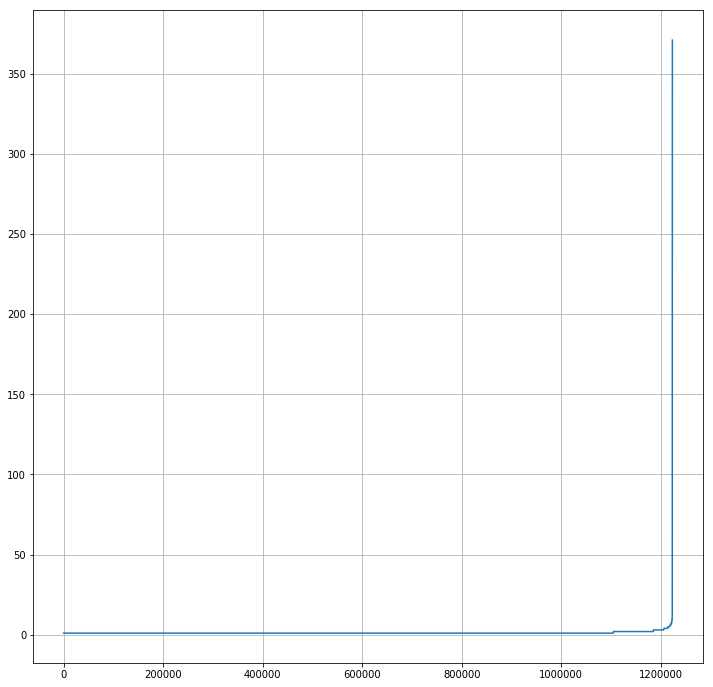

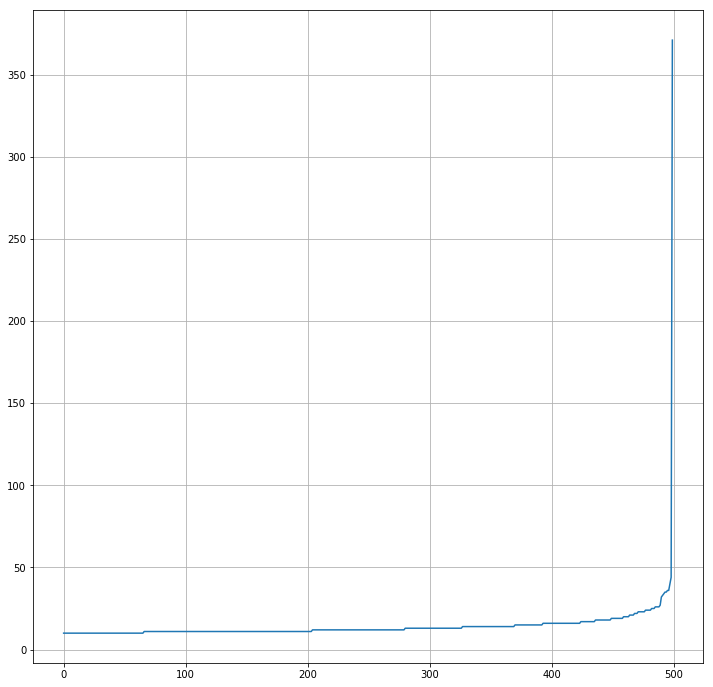

In [68]:
plt.figure(figsize=(12, 12))
plt.plot(list(sorted(goodlist_lvl3_distr_full_2h_values)))
plt.grid()
plt.show()

plt.figure(figsize=(12, 12))
plt.plot(list(sorted(goodlist_lvl3_distr_full_2h_values))[-500:])
plt.grid()
plt.show()

In [69]:
pd.DataFrame({'topic': goodlist_lvl3_distr_full_2h_keys, 'count' : goodlist_lvl3_distr_full_2h_values}).to_csv('./retro/lvl3_dstr_total.csv')

### to csr_matrix

In [108]:
vect_lvl3_distr_full_2h_keys = {}
it = 0
for x in goodlist_lvl3_distr_full_2h_keys:
    vect_lvl3_distr_full_2h_keys[x] = it
    it += 1

In [117]:
csr_lvl3_distr_full_2h = csr_matrix((len(list_lvl3_distr_full_2h), TOTAL_LVL3_TOPICS), dtype=np.int8).toarray()
csr_lvl3_distr_full_2h.shape

(371, 1223471)

In [118]:
type(csr_lvl3_distr_full_2h)

numpy.ndarray

In [119]:
i = 0
for x in list_lvl3_distr_full_2h:
    print(i, end=' ')
    for y in x:
        csr_lvl3_distr_full_2h[i, vect_lvl3_distr_full_2h_keys[y['_id']]] = y['counted']
    i += 1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [135]:
len(np.argwhere(csr_lvl3_distr_full_2h[1] > 1))

261

In [113]:
type(csr_lvl3_distr_full_2h)

numpy.ndarray

In [136]:
from scipy import sparse
sA = sparse.csr_matrix(csr_lvl3_distr_full_2h)
save_npz('./retro/lvl3_dstr_2h_full_count_sparse.npz', sA)

### Не запускать

In [13]:
list_lvl3_distr_full_2h = [{y['_id'] : y['counted'] for y in x} for x in list_lvl3_distr_full_2h]

In [14]:
df_lvl3_distr_full_2h = pd.DataFrame(list_lvl3_distr_full_2h).fillna(0)
df_lvl3_distr_full_2h.to_csv('./retro/lvl3_dstr_2h_full_count.csv')

In [15]:
df_lvl3_distr_full_2h.head()

,154562,157557,157558,157597,157647,157675,157680,157683,157687,157694,...,2066673,2066675,82313575,82319770,2066682,176305,2066683,176269,2066688,176281
0,5.0,1.0,1.0,5.0,2.0,2.0,4.0,2.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
print(df_lvl3_distr_full_2h.values.sum(axis=None), 'of', TOTAL_DOCUMENTS)

167616.0 of 2060904
